In [20]:

import typing as tp

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from datasets import load_dataset

from flax import nnx

np.random.seed(42)
latent_size = 32
image_shape: tp.Sequence[int] = (28, 28)
steps_per_epoch: int = 200
batch_size: int = 64
epochs: int = 1000

dataset = load_dataset('mnist')
X_train = np.array(np.stack(dataset['train']['image']), dtype=np.uint8)
X_test = np.array(np.stack(dataset['test']['image']), dtype=np.uint8)

# Now binarize data
X_train = (X_train > 0).astype(jnp.float32)
X_test = (X_test > 0).astype(jnp.float32)

print('X_train:', X_train.shape, X_train.dtype)
print('X_test:', X_test.shape, X_test.dtype)


X_train: (60000, 28, 28) float32
X_test: (10000, 28, 28) float32


## This is the training setup for the model

In [13]:

class Loss(nnx.Variable):
  pass

class Encoder(nnx.Module):
  def __init__(self, din: int, dmid: int, dout: int, *, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(din, dmid, rngs=rngs)
    self.linear_mean = nnx.Linear(dmid, dout, rngs=rngs)
    self.linear_std = nnx.Linear(dmid, dout, rngs=rngs)
    self.rngs = rngs

  def __call__(self, x: jax.Array) -> jax.Array:
    x = x.reshape((x.shape[0], -1))  # flatten
    x = self.linear1(x)
    x = jax.nn.relu(x)

    mean = self.linear_mean(x)
    std = jnp.exp(self.linear_std(x))

    self.kl_loss = Loss(
      jnp.mean(
        0.5 * jnp.mean(-jnp.log(std**2) - 1.0 + std**2 + mean**2, axis=-1)
      )
    )
    key = self.rngs.noise()
    z = mean + std * jax.random.normal(key, mean.shape)
    return z # is the latent variable, using the reparameterization trick


class Decoder(nnx.Module):
  def __init__(self, din: int, dmid: int, dout: int, *, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(din, dmid, rngs=rngs)
    self.linear2 = nnx.Linear(dmid, dout, rngs=rngs)

  def __call__(self, z: jax.Array) -> jax.Array:
    z = self.linear1(z)
    z = jax.nn.relu(z)
    logits = self.linear2(z)
    return logits


class VAE(nnx.Module):
  def __init__(
    self,
    din: int,
    hidden_size: int,
    latent_size: int,
    output_shape: tp.Sequence[int],
    *,
    rngs: nnx.Rngs,):
    
    self.output_shape = output_shape
    self.encoder = Encoder(din, hidden_size, latent_size, rngs=rngs)
    self.decoder = Decoder(
      latent_size, hidden_size, int(np.prod(output_shape)), rngs=rngs
    )

  def __call__(self, x: jax.Array) -> jax.Array:
    z = self.encoder(x)
    logits = self.decoder(z)
    logits = jnp.reshape(logits, (-1, *self.output_shape))
    return logits

  def generate(self, z):
    logits = self.decoder(z)
    logits = jnp.reshape(logits, (-1, *self.output_shape))
    return nnx.sigmoid(logits)


model = VAE(
  din=int(np.prod(image_shape)),
  hidden_size=256,
  latent_size=latent_size,
  output_shape=image_shape,
  rngs=nnx.Rngs(0, noise=1),
)

optimizer = nnx.Optimizer(model, optax.adam(1e-3))

# %%
@nnx.jit
def train_step(model: VAE, optimizer: nnx.Optimizer, x: jax.Array):
  def loss_fn(model: VAE):
    logits = model(x)
    losses = nnx.pop(model, Loss)
    kl_loss = sum(jax.tree_util.tree_leaves(losses), 0.0)
    reconstruction_loss = jnp.mean(
      optax.sigmoid_binary_cross_entropy(logits, x)
    )
    loss = reconstruction_loss + 0.1 * kl_loss
    return loss

  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)

  return loss


@nnx.jit
def forward(model: VAE, x: jax.Array) -> jax.Array:
  y_pred = model(x)
  return jax.nn.sigmoid(y_pred)


@nnx.jit
def sample(model: VAE, z: jax.Array) -> jax.Array:
  return model.generate(z)

# %%
for epoch in range(epochs):
  losses = []
  for step in range(steps_per_epoch):
    idxs = np.random.randint(0, len(X_train), size=(batch_size,))
    x_batch = X_train[idxs]

    loss = train_step(model, optimizer, x_batch)
    losses.append(np.asarray(loss))
  if epoch % 10 == 0:
    print(f'Epoch {epoch} loss: {np.mean(losses)}')


Epoch 0 loss: 0.306612104177475
Epoch 10 loss: 0.17254364490509033
Epoch 20 loss: 0.16273239254951477
Epoch 30 loss: 0.15935459733009338
Epoch 40 loss: 0.15738171339035034
Epoch 50 loss: 0.15582092106342316
Epoch 60 loss: 0.154928520321846
Epoch 70 loss: 0.15402397513389587
Epoch 80 loss: 0.15262721478939056
Epoch 90 loss: 0.15370288491249084
Epoch 100 loss: 0.15261563658714294
Epoch 110 loss: 0.15244249999523163
Epoch 120 loss: 0.15155242383480072
Epoch 130 loss: 0.151910662651062
Epoch 140 loss: 0.15056286752223969
Epoch 150 loss: 0.1502770632505417
Epoch 160 loss: 0.15080085396766663
Epoch 170 loss: 0.14978118240833282
Epoch 180 loss: 0.15017658472061157
Epoch 190 loss: 0.14997711777687073
Epoch 200 loss: 0.14982454478740692
Epoch 210 loss: 0.14888374507427216
Epoch 220 loss: 0.1490073949098587
Epoch 230 loss: 0.1489880532026291
Epoch 240 loss: 0.14834409952163696
Epoch 250 loss: 0.1488914042711258
Epoch 260 loss: 0.1476995050907135
Epoch 270 loss: 0.1481781154870987
Epoch 280 loss:

## This is compare between true samples and reconstructed samples

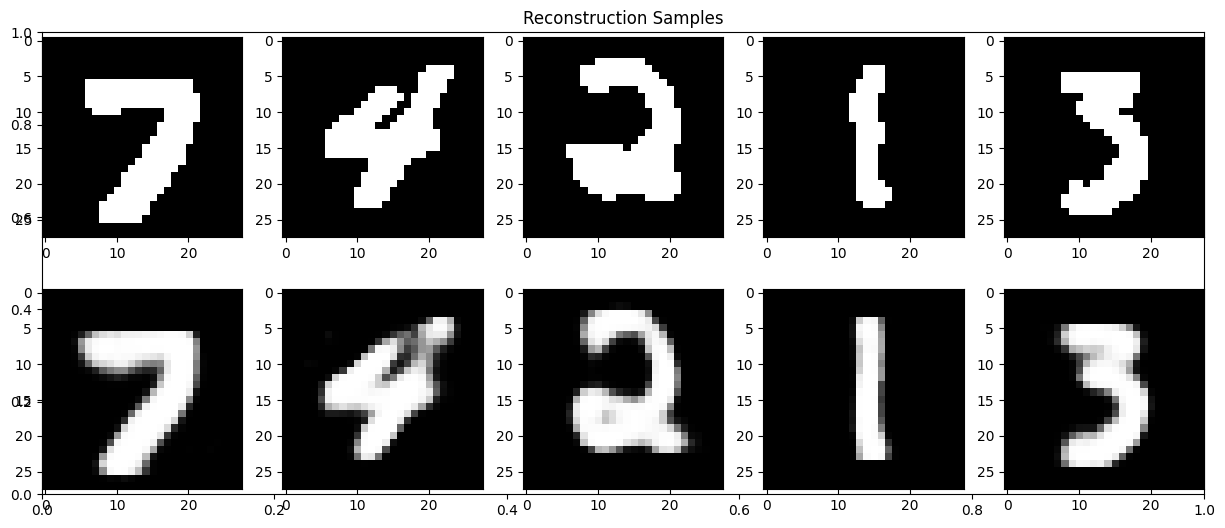

In [14]:

# get random samples
idxs = np.random.randint(0, len(X_test), size=(5,))
x_sample = X_test[idxs]

# get predictions
y_pred = forward(model, x_sample)

# plot reconstruction
figure = plt.figure(figsize=(3 * 5, 3 * 2))
plt.title('Reconstruction Samples')
for i in range(5):
  plt.subplot(2, 5, i + 1)
  plt.imshow(x_sample[i], cmap='gray')
  plt.subplot(2, 5, 5 + i + 1)
  plt.imshow(y_pred[i], cmap='gray')
  # # tbwriter.add_figure("VAE Example", figure, epochs)

plt.show()


## Generative samples 

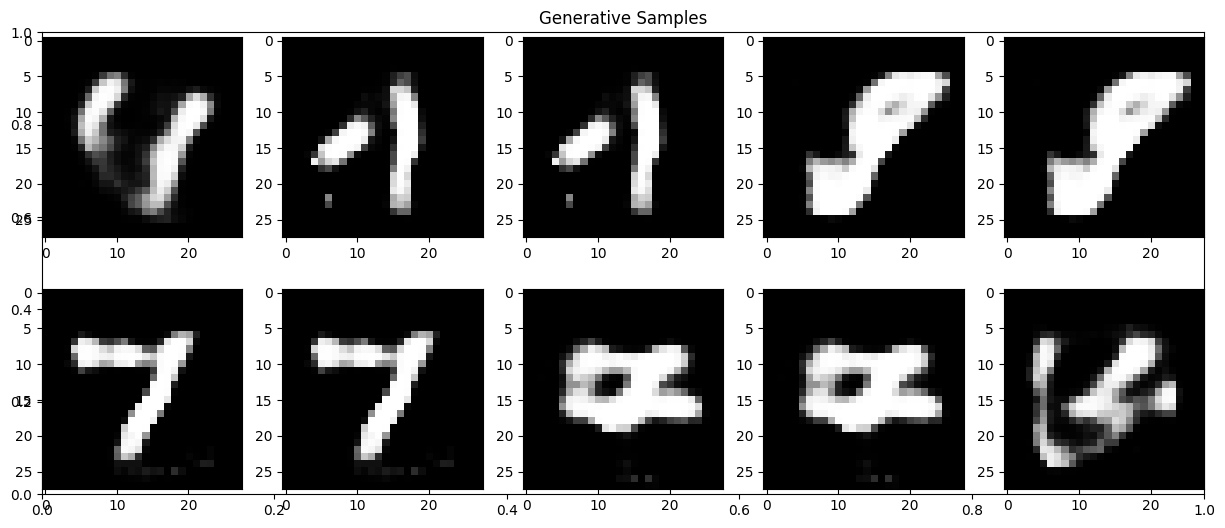

In [19]:
# %%
# plot generative samples
z_samples = np.random.normal(scale=1.5, size=(10, latent_size))
samples = sample(model, z_samples)

figure = plt.figure(figsize=(3 * 5, 3 * 2))
plt.title('Generative Samples')
for i in range(5):
  plt.subplot(2, 5, 2 * i + 1)
  plt.imshow(samples[i], cmap='gray')
  plt.subplot(2, 5, 2 * i + 2)
  plt.imshow(samples[i + 1], cmap='gray')

plt.show()

# %%